In [1]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd

# Data

In [2]:
training = pd.read_csv('Data/TrainingWiDS2021.csv', index_col=0)

In [3]:
test = pd.read_csv('Data/UnlabeledWiDS2021.csv', index_col=0)

In [4]:
train_is_positive = training['diabetes_mellitus']==1
train_is_negative = ~train_is_positive

# Analysis

## Helpers

In [5]:
def hist_by_diagnosis(feature):
    x = training[feature]
    plt.hist([x[train_is_positive], x[train_is_negative]])
    plt.title(f'Distribution of Diagnosis by {feature}')
    plt.legend(["+", "-"])

## Age

C:\Users\Brian\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Brian\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


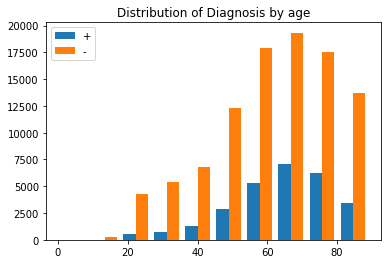

In [6]:
hist_by_diagnosis('age')

# Prediction

## Helpers

In [7]:
import sklearn.linear_model as lm
import sklearn.neighbors as nb
import sklearn.tree as tree
import sklearn.preprocessing as pp

In [8]:
def balance_training():
    has_diabetes = training[train_is_positive].sample(25000)
    no_diabetes = training[train_is_negative].sample(25000)
    return pd.concat([has_diabetes,no_diabetes])

In [65]:
def fillna(dtype, val):
    selected_cols = [col for col in training.columns if training[col].dtype == dtype]
    for col in selected_cols:
        training[col] = training[col].fillna(val)
        if col in test:
            test[col] = test[col].fillna(val)

In [21]:
def encode(column):
    global training
    global test
    all_data = pd.concat([training[[column]], test[[column]]])
    encoder = pp.OneHotEncoder()
    encoder.fit(all_data)
    columns = [column + ": " + category for category in encoder.categories_[0]]
    def apply(df):
        encodings = encoder.transform(df[[column]]).toarray()
        encodings_df = pd.DataFrame(encodings, columns=columns, index=df.index)
        df = df.join(encodings_df)
        return df.drop(columns=column)
    training = apply(training)
    test = apply(test)

In [10]:
def execute(classifier, features):
    classifier.fit(training[features], training['diabetes_mellitus'])
    test['diabetes_mellitus']=classifier.predict(test[features])
    write_solution(test)
    return classifier

In [11]:
def write_solution(solution):
    results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
    results.to_csv('Data/results.csv')

## Data Preparation

In [12]:
training = balance_training()

In [13]:
training['bmi'] = pd.to_numeric(training['bmi'])
test['bmi'] = pd.to_numeric(test['bmi'])

In [14]:
training['age'] = training['age'].fillna(0)

In [15]:
training['bmi'] = training['bmi'].fillna(0)
test['bmi'] = test['bmi'].fillna(0)

In [16]:
training['glucose_apache'] = training['glucose_apache'].fillna(0)
test['glucose_apache'] = test['glucose_apache'].fillna(0)

In [17]:
training['ethnicity'] = training['ethnicity'].fillna("Other/Unknown")
test['ethnicity'] = test['ethnicity'].fillna("Other/Unknown")

In [58]:
fillna('O', "Other")

In [66]:
fillna('int64', 0)
fillna('float64', 0)

In [67]:
for col in test.columns:
    if training[col].dtype == 'O':
        encode(col)

## Diagnosis = 0

In [53]:
solution = pd.read_csv('Data/SolutionTemplateWiDS2021.csv', index_col=0)

In [54]:
test['diabetes_mellitus'] = 0

In [55]:
write_solution(test)

## Diagnosis = elective_surgery

In [56]:
test['diabetes_mellitus'] = test['elective_surgery']

In [57]:
write_solution(test)

## Age logistic regression

In [58]:
clf = execute(lm.LogisticRegression(), ['age'])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [59]:
X_test = np.linspace(0,100,300)

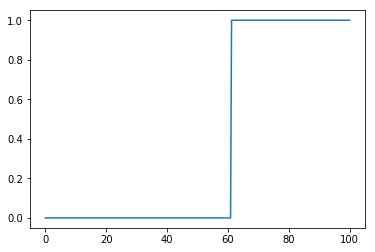

In [60]:
plt.plot(X_test, clf.predict(X_test[:,None]));

## Age + BMI logistic regression

In [61]:
execute(lm.LogisticRegression(), ['age', 'bmi']);

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Age + BMI kNN classifier

In [62]:
execute(nb.KNeighborsClassifier(), ['age','bmi']);

## Age, BMI, Glucose Apache kNN

In [63]:
execute(nb.KNeighborsClassifier(), ['age','bmi','glucose_apache']);

## Age, BMI, Glucose Apache logistic regression

In [64]:
execute(lm.LogisticRegression(), ['age','bmi','glucose_apache']);

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Decision Tree

In [65]:
execute(tree.DecisionTreeClassifier(), ['age','bmi','glucose_apache']);

## Logistic Regression all features

In [70]:
clf = execute(lm.LogisticRegression(), test.columns);

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KeyboardInterrupt: 

# Miscellaneous